In [ ]:
import os
import numpy as np
from scipy.ndimage import uniform_filter
from scipy.io import loadmat, savemat
from pprint import pprint

parameters = ['MMD_D', 'MMD_Delta', 'MMD_ita', 'MMD_psi', 'MMT_A',
            'MMT_P1', 'MMT_P2', 'MMT_P3', 'MMT_P4', 'MMT_P5', 'MMT_P6', 'MMT_P7', 'MMT_P8', 'MMT_P9', 'MMT_b',
            'MMT_beta', 'MMT_t', 'MMT_t_1213', 'MMT_t_2131', 'MMT_t_2434', 'MMT_t_4243']

def read_mask_from_dir(dir_name):
    mask_cell_dir = dir_name+'/mask_cell.mat'
    mask_colloid_dir = dir_name+'/mask_colloid.mat'
    mask_fiber_dir = dir_name+'/mask_fiber.mat'
    mask_none_dir = dir_name+'/mask_none.mat'
    data_dir = dir_name+'/MMparameters.mat'
    if not os.path.exists(data_dir):
        print(f"ERROR! MMparameters.mat of {dir_name} is missing.")
        return
    else:
        #print(f"Reading MMparameters.mat of {dir_name}...")
        data=loadmat(data_dir) 
        temp=[]
        for parameter in parameters:
            temp.append(uniform_filter(data[parameter],10))
        picture=np.stack(temp,axis=2) #shape=(1541, 2291, 28) 
    
    cell=[]
    colloid=[]
    fiber=[]
    none = []
    
    if not os.path.exists(mask_cell_dir):
        print(f"Mask_cell.mat of {dir_name} is missing.")
    else:
        mask_cell=loadmat(mask_cell_dir)['mask']==1
        cell.extend(picture[mask_cell])
        #print(f'The num of cell is {np.sum(mask_cell)}')
        
    if not os.path.exists(mask_colloid_dir):
        print(f"Mask_colloid.mat of {dir_name} is missing.")
    else:
        #print(f"Reading Mask_colloid.mat of {file_name}/{part} ...")
        mask_colloid=loadmat(mask_colloid_dir)['mask']==1 #shape=(1541, 2291)
        colloid.extend(picture[mask_colloid])
        #print(f'The num of colloid is {np.sum(mask_colloid)}')
       

    if not os.path.exists(mask_fiber_dir):
        print(f"Mask_fiber.mat of {dir_name} is missing.")
    else:
        #print(f"Reading Mask_fiber.mat of {file_name}/{part} ...")
        mask_fiber=loadmat(mask_fiber_dir)['mask']==1
        fiber.extend(picture[mask_fiber])
        #print(f'The num of fibers is {np.sum(mask_fiber)}')
        
    if not os.path.exists(mask_none_dir):
        pass
        #print(f"Mask_none.mat of {dir_name} is missing.")
    else:
        print(f"Reading Mask_none.mat of {dir_name} ...")
        mask_none=loadmat(mask_none_dir)['mask']==1
        none.extend(picture[mask_none])
        #print(f'The num of none is {np.sum(mask_none)}')
    
    return cell, colloid, fiber, none

#### 切分数据集（img分为patch和CPM，用numpy存储）

In [2]:
import os
import numpy as np
from scipy.ndimage import uniform_filter
from scipy.io import loadmat, savemat
from pprint import pprint


from patchify import patchify
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  
matplotlib.use('Agg') 

parameters = ['MMD_D', 'MMD_Delta', 'MMD_ita', 'MMD_psi', 'MMT_A',
            'MMT_P1', 'MMT_P2', 'MMT_P3', 'MMT_P4', 'MMT_P5', 'MMT_P6', 'MMT_P7', 'MMT_P8', 'MMT_P9', 'MMT_b',
            'MMT_beta', 'MMT_t', 'MMT_t_1213', 'MMT_t_2131', 'MMT_t_2434', 'MMT_t_4243']

def softmax_T(x, T):
    e_x = np.exp(x / T)
    return e_x / e_x.sum(axis=1, keepdims=True)

def save_model(model_name, clf):
    dir_name = 'E:/yaoyao/workspace/cancer/yaoyao/space/sp/results/3/'
    with open(dir_name+model_name, 'wb') as file:
        pickle.dump(clf, file)

def load_model(model_name):
    dir_name = 'E:/yaoyao/workspace/cancer/yaoyao/space/sp/results/3/'
    with open(dir_name+model_name, 'rb') as file:
        clf = pickle.load(file)
    return clf

def get_CPM_picture(picture, model):
    # 232,94,200 fiber
    #166,71,169 cell
    #241,151,229 coll
    color_cell = [166,71,169]
    color_coll = [241,151,229]
    color_fiber = [232,94,200]
    color_none = [255,255,255]
    pic_shape = picture.shape
    picture_train = np.reshape(picture, (-1, picture.shape[-1]))
    y_proba = model.predict_proba(picture_train.astype(np.float32))
    y_proba = softmax_T(y_proba, 0.05)
    color_mat_cell = np.repeat(y_proba[:,0].reshape((-1, 1)),3,axis=1) * np.array([color_cell])
    color_mat_coll = np.repeat(y_proba[:,1].reshape((-1, 1)),3,axis=1) * np.array([color_coll])
    color_mat_fiber = np.repeat(y_proba[:,2].reshape((-1, 1)),3,axis=1) * np.array([color_fiber])
    color_mat_none = np.repeat(y_proba[:,3].reshape((-1, 1)),3,axis=1) * np.array([color_none])
    color_mat = color_mat_cell+color_mat_coll+color_mat_fiber+color_mat_none
    color_mat_1 = np.reshape(color_mat, (pic_shape[0], pic_shape[1], 3))
    return np.reshape(y_proba, (pic_shape[0], pic_shape[1], 4)), color_mat_1.astype("uint8")

clean_dir_name = 'E:/yaoyao/workspace/cancer/yaoyao/space/sp/test4/20220905/'
clf = load_model('tranin_on_full.pkl')
dry_run = True
for file_name in os.listdir(clean_dir_name):
    file_dir = os.path.join(clean_dir_name, file_name)
    # 如果全部是数字的文件夹名，则是第一批数据 (跳过)
    if not file_name.isdigit() and os.path.isdir(file_dir):
        #存储一个切片的不同部分
        for part in os.listdir(file_dir):
            if dry_run:
                cur_path = file_dir+'/'+ part
                print(cur_path)
                clean_data_dir = cur_path+'/MMparameters.mat'
                data=loadmat(clean_data_dir) 
                temp=[]
                for parameter in parameters:
                    temp.append(uniform_filter(data[parameter],10))
                picture=np.stack(temp,axis=2)
                patch_dir = cur_path + '/' + 'patch_split/'
                if not os.path.exists(patch_dir):
                    os.mkdir(patch_dir)
                    #print("origal shape: ", picture.shape)
                    patches = patchify(picture, (224,224,21), step=112)
                    index = 0
                    print(patches.shape)
                    output, predict_picutre = get_CPM_picture(picture, clf)
                    plt.figure()
                    plt.imshow(predict_picutre)
                    plt.tight_layout()
                    plt.axis("off")
                    plt.savefig(patch_dir+'whole_predict.png', dpi=300)
                    plt.close()
                    for i in range(patches.shape[0]):
                        for j in range(patches.shape[1]):
                            single_patch = patches[i,j,0,:,:,:]
                            #print("input shape:", single_patch.shape)
                            index+=1
                            output, predict_picutre = get_CPM_picture(single_patch, clf)
                            
                            #print("output shape", output.shape )
                            np.save(patch_dir+str(index)+'_input.npy',single_patch)
                            np.save(patch_dir+str(index)+'_output.npy',output)
                            plt.figure()
                            plt.imshow(predict_picutre)
                            plt.tight_layout()
                            plt.axis("off")
                            plt.savefig(patch_dir+str(index)+'.png', dpi=300)
                            plt.close()


KeyboardInterrupt: 

#### 自定义resnet用于图像重建

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchsummary import summary
# yaoyao
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101']

class ResNet(nn.Module):
    def __init__(self, in_channel, out_channel, dropout=True, base_model='resnet50', pretrained=True):
        super(ResNet, self).__init__()
        if base_model == 'resnet18':
            if pretrained:
                backbone = models.resnet18(pretrained=True)
            else:
                backbone = models.resnet18(pretrained=False)
        elif base_model == 'resenet34':
            if pretrained:
                backbone = models.resnet34(pretrained=True)
            else:
                backbone = models.resnet34(pretrained=False)
        elif base_model == 'resnet50':
            if pretrained:
                backbone = models.resnet50(pretrained=True)
            else:
                backbone = models.resnet50(pretrained=False)
        elif base_model == 'resnet101':
            if pretrained:
                backbone = models.resnet101(pretrained=True)
            else:
                backbone = models.resnet101(pretrained=False)
        else:
            if pretrained:
                backbone = models.resnet50(pretrained=True)
            else:
                backbone = models.resnet50(pretrained=False)
        backbone.conv1 = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3,
                                         bias=False)
        nn.init.kaiming_normal_(backbone.conv1.weight, mode='fan_out', nonlinearity='relu')
        #modules = list(backbone.children())[:-2]      # delete the last fc layer and the avgpool.(ResnetVAE)
        modules = list(backbone.children())[:-1]      # delete the last fc layer
        self.resnet = nn.Sequential(*modules)
        fc = [nn.Linear(backbone.fc.in_features, 1024), nn.ReLU()] # 如果考虑进一步压缩
        if dropout:
            fc.append(nn.Dropout(0.25))
        self.fc = nn.Sequential(*fc)
        self.conv_seg = nn.Sequential(
            # nn.ConvTranspose2d(backbone.fc.in_features, 32, kernel_size=3, stride=2, padding=0), 如果删去了avgpool，这里的in_features就是64*4*4
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0), # 直接使用resnet50的fc层, 这里的in_features就是64，使用了reshape
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=out_channel, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(out_channel, momentum=0.01),
            nn.Sigmoid()
            # nn.Softmax(dim=1) # 强制使用softmax分类
            # nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0,bias=False),
            # nn.BatchNorm2d(32),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(32, out_channel, kernel_size=1, stride=1, bias=False)
        )
        if pretrained:
            # 仅kaiming初始化decoder
            for m in self.conv_seg.children():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
                    m.bias.data.zero_()
                # 也可以判断是否为conv2d，使用相应的初始化方式
                elif isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
            for m in self.fc.children():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
        else:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out',nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
                    m.bias.data.zero_()

    def encode(self, x):
        x = self.resnet(x)
        #x = nn.AdaptiveAvgPool2d(output_size=(1, 1))(x)
        return x

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(-1, 64, 4, 4)
        x = self.conv_seg(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

In [2]:
device = torch.device( "cuda:0") 
a = ResNet(in_channel=21, out_channel=4, base_model='resnet101', pretrained=True).to(device)
input_tensor = torch.rand(7, 21, 224, 224).to(device)  # batch_size,input_channel,input_h,input_w
out = a(input_tensor)
print(out.shape)
#summary(a, (21, 224, 224))

d:\Anaconda\setup\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\setup\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([7, 4, 224, 224])


#### 自定义数据集patch粒度

In [3]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
class PATCH_IMG(Dataset):
    def __init__(self, train=True, transform = None):
        super(PATCH_IMG, self).__init__()
        self.train = train
        self.transform = transform
        self.filenames = []
        self.labels = []
        dir_name = 'E:/yaoyao/workspace/cancer/yaoyao/space/sp/test4/20220905/'
        if self.train:
            for file_name in ['C1901130-A3', 'C1902194-A3','C1904464-A5','C1906095-A4', "C2001254-A2","C2001254-A5"]:
                file_dir = os.path.join(dir_name, file_name)
                for part in os.listdir(file_dir):
                    cur_path = file_dir+'/'+ part + '/patch_split/'
                    for i in range(1,261):
                        self.filenames.append(cur_path+str(i)+'_input.npy')
                        self.labels.append(cur_path+str(i)+'_output.npy')
        else:
            for file_name in ["C2001254-A3", 'C2004546-A5','C2007095-A21']:
                file_dir = os.path.join(dir_name, file_name)
                for part in os.listdir(file_dir):
                    cur_path = file_dir+'/'+ part + '/patch_split/'
                    for i in range(1,261):
                        self.filenames.append(cur_path+str(i)+'_input.npy')
                        self.labels.append(cur_path+str(i)+'_output.npy')

    def __getitem__(self, index):
        img_name = self.filenames[index]
        label_name = self.labels[index]
        img = np.load(img_name)
        label = np.load(label_name)
        if self.transform is not None:
            img = self.transform(img)
            label = self.transform(label)
        return img, label

    def __len__(self):
        return len(self.filenames)

#### 读取数据集测试

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import torch


# 训练集
train_dataset = PATCH_IMG(train=True, transform = transforms.Compose([
transforms.ToTensor(),
]))

# 测试集
test_dataset = PATCH_IMG(train=False, transform = transforms.Compose([
transforms.ToTensor(),
]))

print("训练集，测试集的大小分别为：")
print(len(train_dataset), len(test_dataset))
img,label= train_dataset.__getitem__(1)
print(label.shape)
print(img.shape)
# imshow(img)
# 可视化img


# train_loader = DataLoader(dataset=train_dataset, batch_size=9, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=9, shuffle=False)

# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))

训练集，测试集的大小分别为：
5200 2340
torch.Size([4, 224, 224])
torch.Size([21, 224, 224])


In [5]:
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import random
import gc
class argparse():
    pass

args = argparse()
args.epochs, args.learning_rate, args.patience = [30, 0.01, 5]
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Batch_size = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=Batch_size, shuffle=False)

cnn = ResNet(in_channel=21, out_channel=4, base_model='resnet50', pretrained=True).to(args.device)
optimizer = torch.optim.SGD(cnn.parameters(), lr=args.learning_rate, momentum=0.9, nesterov=True)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_func = nn.MSELoss()
train_loss = []
test_loss = []
train_epochs_loss = []
test_epochs_loss = []
train_acc = []
test_acc = []

#early_stopping = EarlyStopping(patience=args.patience,verbose=True)
first = True
for epoch in range(args.epochs):
    cnn.train()
    train_epoch_loss = []
    total_accuracy = 0
    for idx,(data_x,data_y) in enumerate(train_loader):
        data_x = data_x.type(torch.float32).to(args.device)
        data_y = data_y.type(torch.float32).to(args.device)
        outputs = cnn(data_x)
        optimizer.zero_grad()
        loss = loss_func(outputs, data_y)
        loss.backward()
        optimizer.step()
        if first:
            print("argmax shape:",outputs.argmax(1).shape)
            first = False
        accuracy = int((outputs.argmax(1) == data_y.argmax(1)).sum())
        total_accuracy = total_accuracy + accuracy
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//5)==0:
            # gc.collect()
            # torch.cuda.empty_cache()
            print("Epoch={}/{}, {}/{} of train, loss={:.4f}, acc={:.4f}".format(
                epoch, args.epochs, idx, len(train_loader), loss.item(), accuracy/(Batch_size*224*224.0)))
    train_epochs_loss.append(np.average(train_epoch_loss))
    train_acc.append(total_accuracy/(len(train_dataset)*224*224.0))
    
    #===================test==============================
    cnn.eval()
    test_epoch_loss = []
    total_accuracy = 0
    with torch.no_grad():
        for idx,(data_x,data_y) in enumerate(test_loader):
            data_x = data_x.to(torch.float32).to(args.device)
            data_y = data_y.to(torch.float32).to(args.device)
            outputs = cnn(data_x)
            loss = loss_func(outputs,data_y)
            accuracy = int((outputs.argmax(1) == data_y.argmax(1)).sum())
            total_accuracy = total_accuracy + accuracy
            test_epoch_loss.append(loss.item())
            test_loss.append(loss.item())
    test_epochs_loss.append(np.average(test_epoch_loss))
    test_acc.append(total_accuracy/(len(test_dataset)*224*224.0))
    print("Epoch={}/{}, test_loss={:.4f}, test_acc={:.4f}".format(
                epoch, args.epochs, test_epochs_loss[-1], test_acc[-1]))
    
    #==================early stopping======================
    # early_stopping(valid_epochs_loss[-1],model=cnn,path='F:/yaoyao/workspace/cancer/checkpoint/1005_test')
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break
    
    #====================adjust lr========================
    lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr * 1e2
        print('Updating learning rate to {}'.format(lr))


d:\Anaconda\setup\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\setup\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


argmax shape: torch.Size([32, 224, 224])
Epoch=0/30, 0/163 of train, loss=0.2575, acc=0.2042
Epoch=0/30, 32/163 of train, loss=0.2432, acc=0.2260
Epoch=0/30, 64/163 of train, loss=0.2298, acc=0.2707
Epoch=0/30, 96/163 of train, loss=0.2161, acc=0.2909
Epoch=0/30, 128/163 of train, loss=0.2081, acc=0.3142
Epoch=0/30, 160/163 of train, loss=0.1962, acc=0.3602
Epoch=0/30, test_loss=0.1871, test_acc=0.4265
Epoch=1/30, 0/163 of train, loss=0.1947, acc=0.3606
Epoch=1/30, 32/163 of train, loss=0.1901, acc=0.3613
Epoch=1/30, 64/163 of train, loss=0.1791, acc=0.4515
Epoch=1/30, 96/163 of train, loss=0.1766, acc=0.4239
Epoch=1/30, 128/163 of train, loss=0.1686, acc=0.4377
Epoch=1/30, 160/163 of train, loss=0.1684, acc=0.4702
Epoch=1/30, test_loss=0.1678, test_acc=0.4354
Epoch=2/30, 0/163 of train, loss=0.1663, acc=0.4523
Epoch=2/30, 32/163 of train, loss=0.1678, acc=0.4350
Epoch=2/30, 64/163 of train, loss=0.1584, acc=0.4629
Epoch=2/30, 96/163 of train, loss=0.1575, acc=0.4786
Epoch=2/30, 128/16

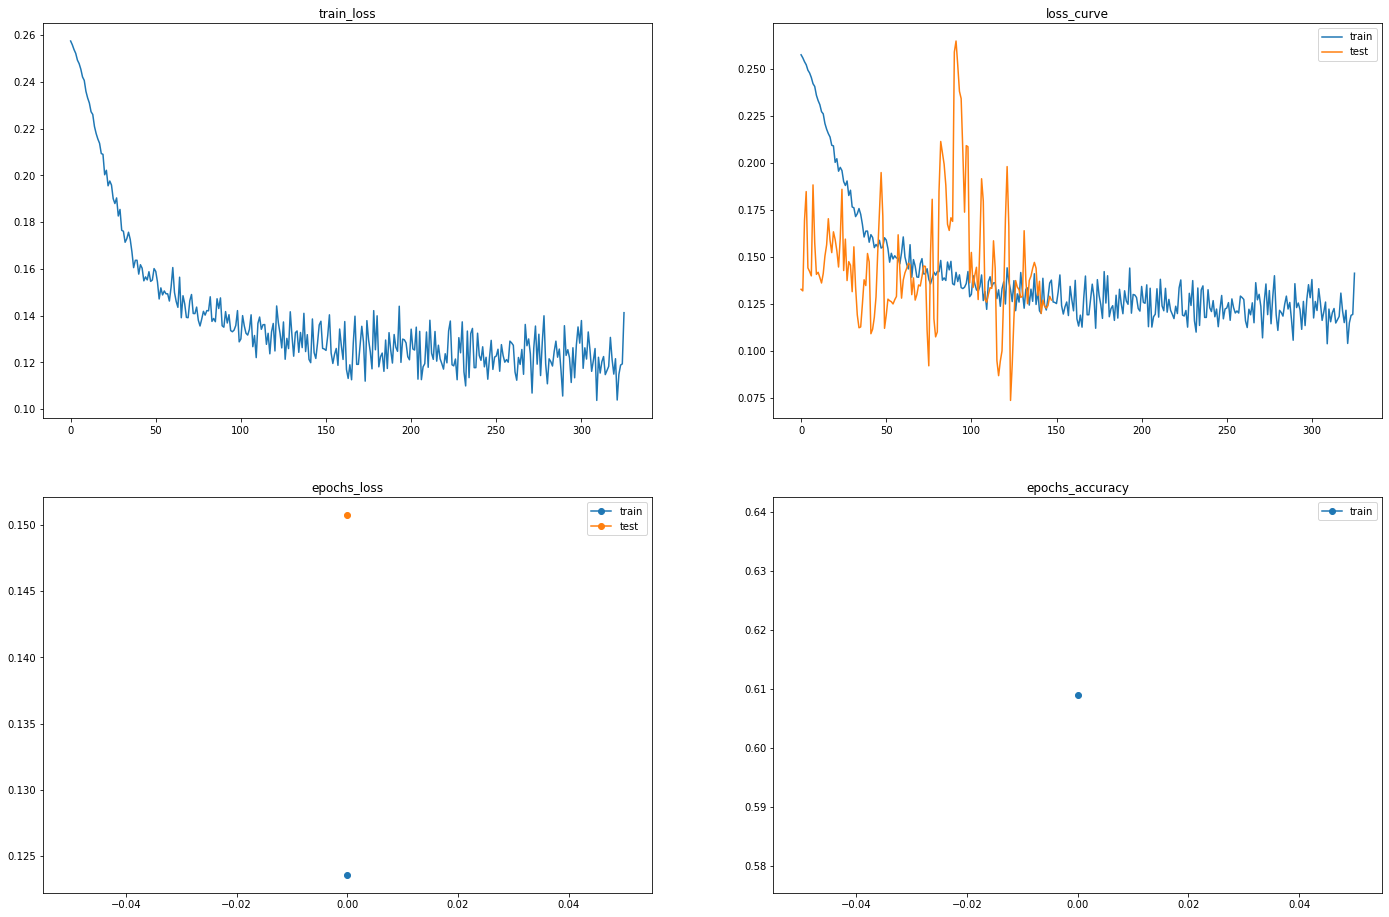

In [7]:
plt.figure(figsize=(24,16))
plt.subplot(221)
plt.plot(train_loss[:])
plt.title("train_loss")

plt.subplot(222)
plt.plot(train_loss[:], label='train')
plt.plot(test_loss[:], label='test')
#plt.plot(valid_loss[:], label='vaild')
plt.title("loss_curve")
plt.legend()

plt.subplot(223)
plt.plot(train_epochs_loss[1:],'-o',label="train")
plt.plot(test_epochs_loss[1:],'-o',label="test")
#plt.plot(valid_epochs_loss[1:],'-o',label="valid")
plt.title("epochs_loss")
plt.legend()

plt.subplot(224)
plt.plot(train_acc[1:],'-o',label="train")
# plt.plot(test_acc[1:],'-o',label="test")
# plt.plot(valid_acc[1:],'-o',label="valid")
plt.title("epochs_accuracy")
plt.legend()
plt.show()

#### 自定义数据集slide粒度

In [ ]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image 
class Muller_IMG(Dataset):
    def __init__(self, train=True, valid=False, transform = None, target_transform=None):
        super(Muller_IMG, self).__init__()
        self.train = train
        self.valid = valid
        self.transform = transform
        self.target_transform = target_transform
        self.filenames = []
        self.labels = []
        dir_name = 'E:/yaoyao/workspace/cancer/yaoyao/space/sp/test4/20220905/'
        if self.train :
            if self.valid:
                file = 'C1901130-A3' # 腺癌
                for part in ['3']:
                    patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                    for patch_file in os.listdir(patch_dir):
                        patch_file_name = patch_dir + patch_file
                        self.filenames.append(patch_file_name)
                        self.labels.append(0)
                file = 'C1902194-A3' # 滤泡癌
                for part in ['3']:
                    patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                    for patch_file in os.listdir(patch_dir):
                        patch_file_name = patch_dir + patch_file
                        self.filenames.append(patch_file_name)
                        self.labels.append(1)
                for file in [ 'C1906095-A4', "C2001254-A3","C2001254-A5"]: # 交界性肿癌
                    for part in ['3']:
                        patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                        for patch_file in os.listdir(patch_dir):
                            patch_file_name = patch_dir + patch_file
                            self.filenames.append(patch_file_name)
                            self.labels.append(2)
            else:
                file = 'C1901130-A3' # 腺癌
                for part in ['1', '2']:
                    patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                    for patch_file in os.listdir(patch_dir):
                        patch_file_name = patch_dir + patch_file
                        self.filenames.append(patch_file_name)
                        self.labels.append(0)
                file = 'C1902194-A3' # 滤泡癌
                for part in ['1', '2']:
                    patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                    for patch_file in os.listdir(patch_dir):
                        patch_file_name = patch_dir + patch_file
                        self.filenames.append(patch_file_name)
                        self.labels.append(1)
                for file in [ 'C1906095-A4', "C2001254-A3","C2001254-A5"]: # 交界性肿癌
                    for part in ['1', '2']:
                        patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                        for patch_file in os.listdir(patch_dir):
                            patch_file_name = patch_dir + patch_file
                            self.filenames.append(patch_file_name)
                            self.labels.append(2)   
        else:
            file = 'C2004546-A5' # 腺癌
            for part in ['1', '2', '3']:
                patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                for patch_file in os.listdir(patch_dir):
                    patch_file_name = patch_dir + patch_file
                    self.filenames.append(patch_file_name)
                    self.labels.append(0)
            file = 'C2007095-A21' # 滤泡癌
            for part in ['1', '2', '3']:
                patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                for patch_file in os.listdir(patch_dir):
                    patch_file_name = patch_dir + patch_file
                    self.filenames.append(patch_file_name)
                    self.labels.append(1)
            for file in ['C2001254-A2']: # 交界性肿癌
                for part in ['1', '2', '3', '4', '5']:
                    patch_dir = dir_name + file +'/'+ part+'/' + 'patch/'
                    for patch_file in os.listdir(patch_dir):
                        patch_file_name = patch_dir + patch_file
                        self.filenames.append(patch_file_name)
                        self.labels.append(2)

    def __getitem__(self, index):
        img_name = self.filenames[index]
        label = self.labels[index]

        # img = plt.imread(img_name)

        img = Image.open(img_name)      
        img = np.array(img)
        
        if self.transform is not None:
            img = self.transform(img)
        # img = img.permute(2, 0, 1) 
        return img, label

    def __len__(self):
        return len(self.filenames)